In [3]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, Simulation
from tqdm import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

from relaxation.estimators import relaxation_finder_collision
import logging
import sys, os
from settings import DFS_PATH
from utils.utils import plot_mean_std, delete_dfs, smoothen, concat

matplotlib.rcParams["figure.dpi"] = 150
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

In [4]:
def standartize(arr):
    return (arr - np.mean(arr))/np.std(arr)

In [5]:
with client.Session() as session:
    query = (session.query(Simulation.id, Simulation.particles, Simulation.group_name)
                 .where(Simulation.group_name.in_(["ER 6.1", "ER 6.2"] ))
                 .order_by(Simulation.start_time)).all()[:]
# query = [x[1] for x in query]
print(len(query))

2897


In [6]:
query[0]

(9957, 37, 'ER 6.1')

In [7]:
%%time
item = client.query_simulation(id=query[0][0], full_load=False)
item.load_history()

CPU times: user 93.4 ms, sys: 186 ms, total: 279 ms
Wall time: 2.03 s


In [8]:
item.history.keys()

dict_keys(['BInertia', 'IE', 'KE', 'L', 'LJ_force', 'OMEGA', 'PE', 'collisions', 'rs', 'time', 'vs'])

In [9]:
delete_list = []
def f(sid):
    
    item = client.query_simulation(id=sid, full_load=False)
    try:
        item.load_df()
            
    except Exception as e:
        delete_list.append(item.history["hdf5"])
        return None
    
    return item

In [10]:
item = f(query[0][0])

In [11]:
items = [f(x) for x, n, _ in tqdm(query[:])]
print("items to delete: ",len(delete_list))

100%|██████████| 2897/2897 [05:55<00:00,  8.16it/s]

items to delete:  0


In [12]:
items = [x for x in items if x is not None]
items = sorted(items, key=lambda x: x.particles)
Ns = sorted(list(set([x.particles for x in items])))

shift = 200

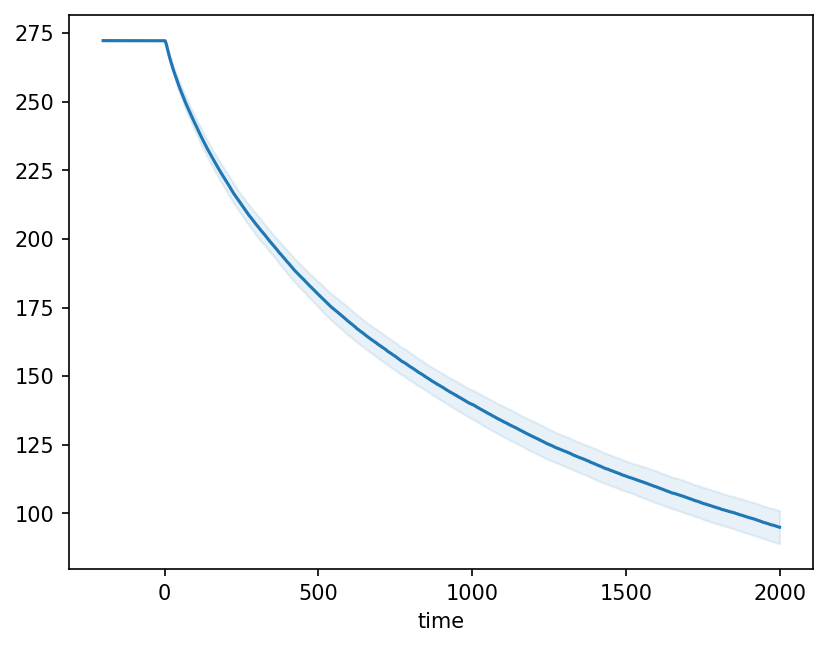

In [13]:
N = 343
df_L = concat([item.df for item in items if item.particles == N],"total_L")
df_L = df_L.set_index(df_L.index-shift)
plot_mean_std(df_L.loc[:2000])

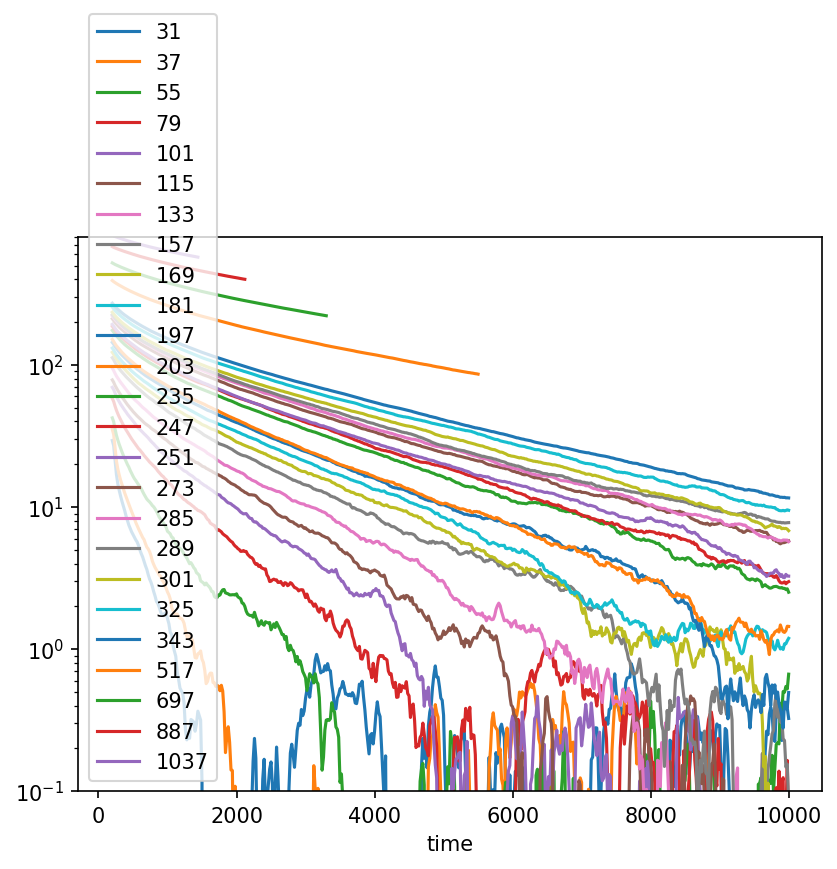

In [14]:
sp=100
for n in Ns:
    df_L = concat([item.df for item in items if item.particles == n ],"total_L")

    df_L.mean(axis=1)[::sp].loc[200:].plot(label=f"{n}")

plt.legend(loc="lower left")
plt.yscale("log")
plt.ylim(0.1,800);

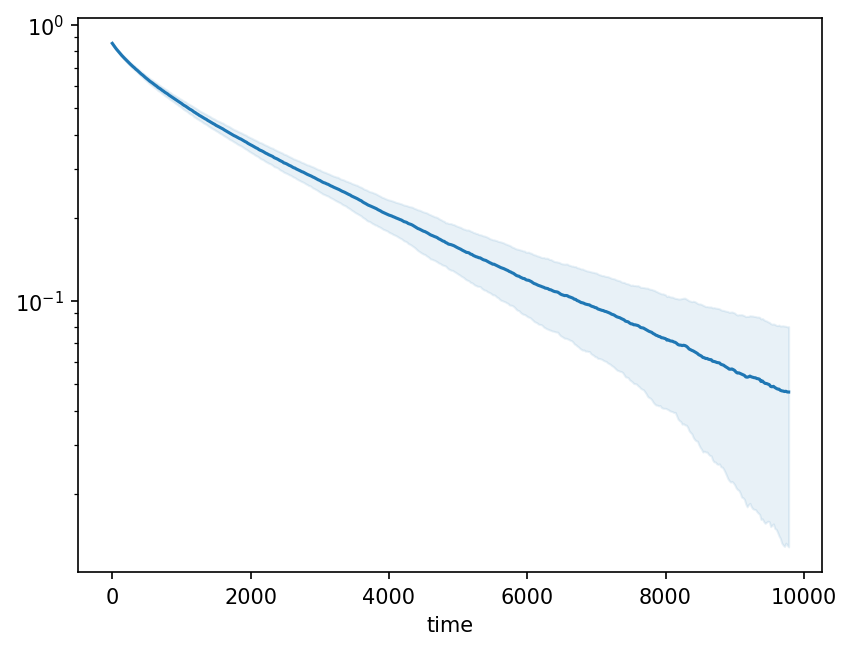

In [15]:
sp = 100
df_omega = concat([smoothen(item.df,5) for item in items if item.particles == N], "omega_MLE")
df_omega.set_index(df_omega.index-shift, inplace=True)
plot_mean_std(df_omega.loc[0::sp])
plt.yscale("log")

In [16]:
items_343 = [item for item in items if item.particles == 343]

item = items_343[0]

In [17]:
item.load_history()

In [18]:
ts, vs, rs = (item.history[key] for key in ["time","vs","rs"])

In [ ]:
df_T.mean(axis=1).loc[:0].iloc[-30:].mean()

In [ ]:
plot_mean_std(df_IE.loc[:], "b", "IE")

In [ ]:
plot_mean_std((df_KPE).loc[:100], "b", "")


In [ ]:
plot_mean_std((df_L).loc[::100])
df_L.loc[::100].plot(ax=plt.gca(), alpha=0.1)
plt.grid()
plt.gca().get_legend().remove()

In [ ]:
O = concat(dfs, "omega_MLE").loc[-100:0].values.mean()
item = items_343[0]

plot_mean_std(concat(dfs,"xx").loc[:0] * (item.a**-2 - O**2), 0, "xx")
plot_mean_std(concat(dfs,"yy").loc[:0]* (item.a**-2 - O**2), 1, "yy")
plot_mean_std(concat(dfs,"zz").loc[-175:0]* ((0.254)**-2), 2, "zz")


### Check beta-omega

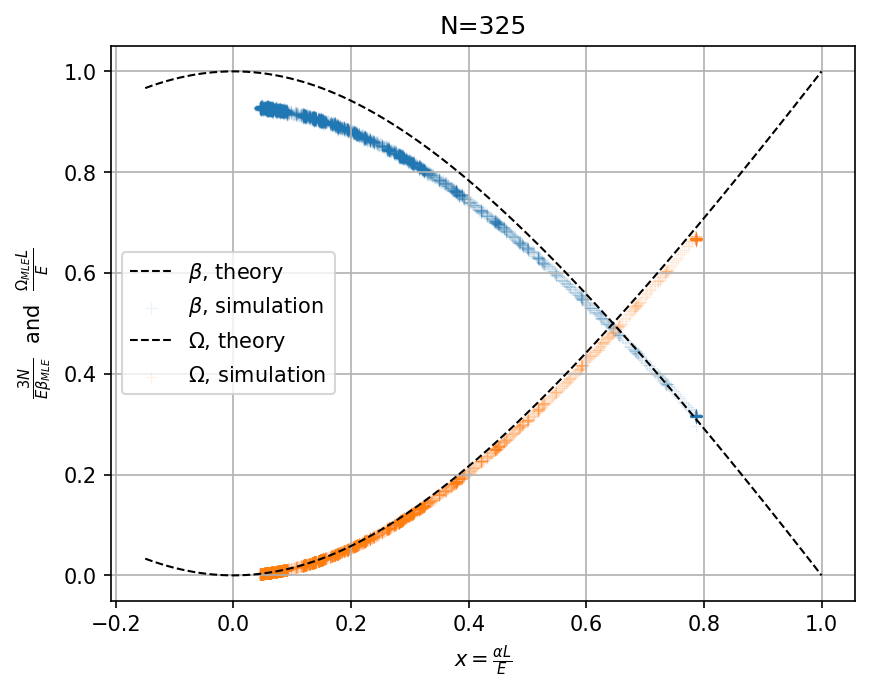

In [33]:
dfs = [item.df.set_index(item.df.index-shift) for item in items if item.particles == Ns[-6]]
df = dfs[0]
N = df["N"].mean()
df_L = concat([df.total_L for df in dfs])
df_T = concat([1/df.beta_MLE for df in dfs])
df_beta = concat([df.beta_MLE for df in dfs])
df_omega = concat([df.omega_MLE for df in dfs])

df_IE = smoothen(concat([df["total_IE"] for df in dfs]),-1)
df_KPE = concat([df["total_E"]-df["total_IE"] for df in dfs])
df_KE = concat([df["total_KE"] for df in dfs])

def f_beta(x):
    x = np.abs(x)
    return 3 * (1 - x**2)/(2 + np.sqrt(1 + 3 * x**2))
def f_omega(x):
    x = np.abs(x)
    return np.sqrt(1 + 3 * x**2) - 1



wind = 10
# omega_arr = smoothen(df_omega, wind).dropna().loc[0:].values.flatten()
# L_arr = smoothen(df_L, wind).dropna().loc[0:].values.flatten()
# beta_arr = smoothen(df_beta, wind).dropna().loc[0:].values.flatten()

omega_arr = smoothen(df_omega, wind).dropna().loc[:].values.flatten()
L_arr = smoothen(df_L, wind).dropna().loc[:].values.flatten()
beta_arr = smoothen(df_beta, wind).dropna().loc[:].values.flatten()


E = dfs[0].total_E.loc[100]

a=np.sqrt(1)

df0 = pd.DataFrame(
    {"x":a * L_arr / E,
     "y_beta": 3 * N/E/beta_arr,
     "y_omega": omega_arr * L_arr / E}
)
df = df0.iloc[::1000]

xs = np.linspace(-0.15,1,200)
alpha=0.1
plt.plot(xs, f_beta(xs), "k--", lw=1, label=r"$\beta$, theory")
plt.scatter(df["x"], df["y_beta"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\beta$, simulation")

plt.plot(xs, f_omega(xs), "k--", lw=1, label="$\Omega$, theory")
plt.scatter(df["x"], df["y_omega"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\Omega$, simulation")


plt.xlabel(r"$x=\frac{\alpha L}{E}$")

plt.ylabel(r"$\frac{3 N}{ E \beta_{MLE} }$  and  $\frac{\Omega_{MLE} L}{E}$")
plt.title(f"N={int(N)}")
plt.legend()
plt.grid()

In [ ]:
plot_mean_std(df_IE)
# plot_mean_std(df_KPE)

In [ ]:
a = np.sqrt(1.04)

df_temps = pd.DataFrame(
{
    "xxyy": 1.00*( (a**2-df_omega**2)*(concat(dfs,"xx") + concat(dfs,"yy"))/2).mean(axis=1),
    "zz":   ( 16*concat(dfs,"zz")).mean(axis=1),
    "KE":   ( 2*concat(dfs,"total_KE")*(a**2-df_omega**2)/(3 * a**2 - df_omega**2)/N ).mean(axis=1),
    "L":    ( concat(dfs,"total_L")*(a**2-df_omega**2)/(df_omega)/N/2 ).mean(axis=1),
    "MLE":  ( df_T.mean(axis=1) )
}
) 

In [ ]:
df_temps.loc[-150:200].plot()
plt.title(f"a={a}");

In [ ]:
df_T

## Interaction effective potential

In [ ]:
items_1000 = [item for item in items if item.particles == Ns[-1]][:50]
[item.load_history() for item in tqdm(items_1000)];

In [ ]:
items_1000[0].history["IE"].shape

In [ ]:
data_r = []
data_IE = []
data_PE = []

dz = 0.01

for item in items_1000:
    t =  item.history["time"]
    
    end = np.argmax(t==400)
    start = int(0.25*end)
    
    rs = item.history["rs"][start:end]
    IE = item.history["IE"][start:end]
    PE = item.history["PE"][start:end]

    r = np.sqrt(rs[:,0]**2 + rs[:,1]**2)
    
    z = np.abs(rs[:,2,:])
    zids = z<dz
    
    if np.sum(zids) == 0:
        continue
    
    data_r.append(r[zids])
    data_IE.append(IE[zids])    
    data_PE.append(PE[zids])

data_r  = np.concatenate(data_r).flatten()
data_IE = np.concatenate(data_IE).flatten()
data_PE = np.concatenate(data_PE).flatten()
print(len(data_r))

In [ ]:
df = pd.DataFrame({"R":data_r, "IE":data_IE, "PE":data_PE})
df.set_index(df.R, inplace=True)
# df = df.sort_values("R")
# df = df.set_index("R")
# df = df.reset_index(drop=True)

In [ ]:
dr = 0.01
gb = df.groupby((df.R/dr).astype(int))

In [ ]:
df_mean = gb.mean()
df_mean.set_index(df_mean.R, inplace=True)
# df_mean = df_mean.loc[:1.5]

In [ ]:
df_mean.PE.plot()
(df_mean.PE+df_mean.IE).plot()
plt.plot(df_mean.R,df_mean.iloc[0].IE+df_mean.iloc[0].PE+0.5*(df_mean.R-df_mean.iloc[0].R)**2 * 1.04)

In [ ]:
df_mean

In [ ]:
gb.IE.mean().plot()
(gb.IE.mean()+10*gb.IE.std()/gb.IE.count()**0.5).plot(style="--")

In [102]:
len(items_1000)

10

### Stationary distribution

In [78]:
items_343 = [item for item in items_6 if item.particles == 343]

In [79]:
item = items_343[0]

In [80]:
item.history

{'BInertia': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'IE': array([[-0.00235907, -0.00235907, -0.00242993, ..., -0.00242993,
         -0.00235907, -0.00235907],
        [-0.00313192, -0.00272993, -0.00177227, ..., -0.00957922,
         -0.00722583, -0.00219392],
        [-0.00482326, -0.00665683, -0.00202834, ..., -0.04053532,
         -0.02242805, -0.00260043],
        ...,
        [-0.08383726, -0.03297794, -0.02460971, ..., -0.03173838,
         -0.03705496,  0.69789004],
        [-0.03104713, -0.00116818,  0.01246466, ..., -0.04276819,
         -0.05485319, -0.08012351],
        [-0.05396714, -0.01855723, -0.0378124 , ...,  0.31620556,
         -0.02917635, -0.05661842]], dtype=float32),
 'KE': array([[0.8210238 , 0.7321569 , 1.0008665 , ..., 0.62743556, 0.977656

In [83]:
item.load_history()

In [97]:
ts, vs, rs = (item.history[key] for key in ["time","vs","rs"])
vs = vs[(ts>120) & (ts<200)].transpose(1,0,2)
rs = rs[(ts>120) & (ts<200)].transpose(1,0,2)

In [99]:
vs.shape

(3, 399, 343)

In [121]:
xis = np.concatenate([vs, rs],axis=0).reshape(6,-1)
cov = np.cov(xis)
lam = np.linalg.inv(cov)

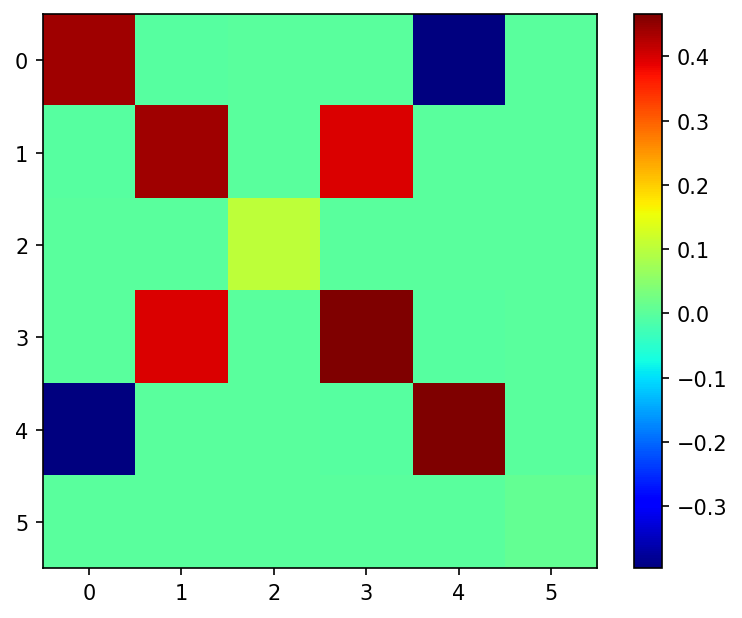

In [114]:
plt.imshow(cov, cmap="jet")
plt.colorbar()

In [142]:
(lam*T).round(3).tolist()

[[0.999, 0.006, 0.0, 0.002, 0.852, -0.016],
 [0.006, 1.002, -0.002, -0.853, -0.002, -0.003],
 [0.0, -0.002, 0.999, 0.002, 0.0, -0.001],
 [0.002, -0.853, 0.002, 0.946, 0.01, 0.002],
 [0.852, -0.002, 0.0, 0.01, 0.946, -0.014],
 [-0.016, -0.003, -0.001, 0.002, -0.014, 13.378]]

In [144]:
T

0.10222555359998649

In [139]:
T = 1/np.mean(lam[(0,1,2),(0,1,2)])

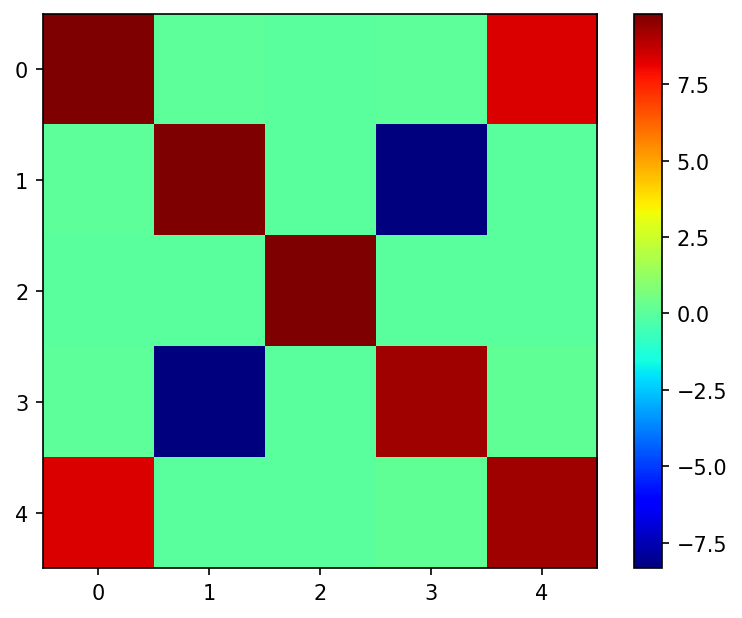

In [126]:
plt.imshow(lam[:5,:5], cmap="jet")
plt.colorbar()

In [120]:
cov.round(3)

array([[ 0.441, -0.004,  0.   , -0.   , -0.397,  0.   ],
       [-0.004,  0.44 ,  0.   ,  0.397, -0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.102, -0.   , -0.   ,  0.   ],
       [-0.   ,  0.397, -0.   ,  0.466, -0.004,  0.   ],
       [-0.397, -0.   , -0.   , -0.004,  0.465, -0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.008]])

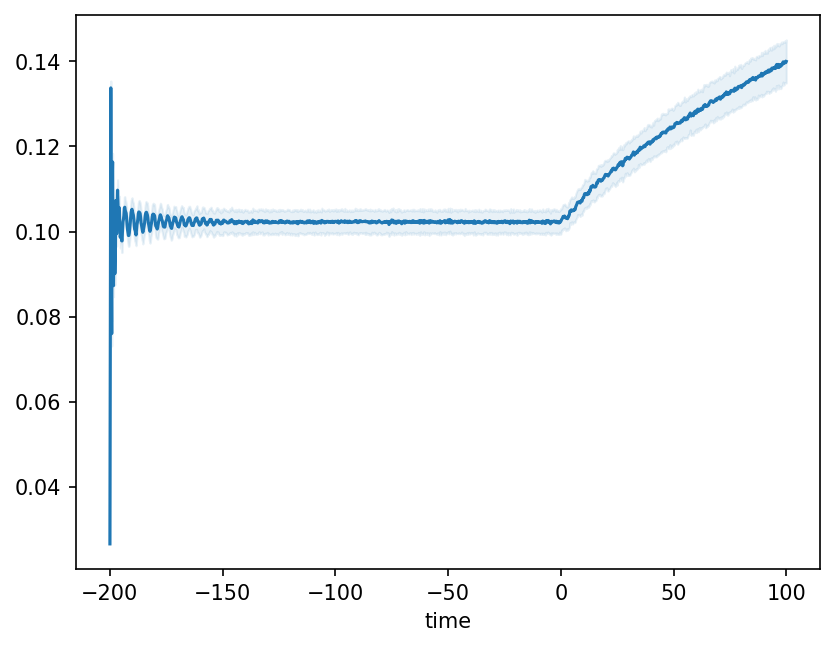

In [90]:
plot_mean_std(df_T[:100])